###Toronto Maple Leafs 2024-25 Poisson Simulation

### *Goals*:
- Using xG values For and Against, resimulate all 82 Toronto Maple Leafs regular season games from the 2024-2025 season using the Poisson Distribution.
- Compare actual results to expected results over the course of the season. Treat overtime losses as regulation losses, for simplicity.
- Provide written analysis of methods and results within the Python Notebook.

Data available as a CSV: `data/leafs_2425.csv`

In [1]:
"""
Pipeline Overview: Toronto Maple Leafs 2024-25 Regular Season Analysis

1. Load Data: Import actual and expected goals (xGF/xGA) for all regular-season games.
2. Game Simulation: Use Poisson distributions to simulate each game, treating ties as 50/50 coin flips, and compute expected goals, win probabilities, and points.
3. Season Summary: Aggregate expected vs actual totals (wins, points, GF, GA) and display cumulative points over the season.
4. Accuracy Assessment: Compare actual vs expected goals with scatter plots, regression metrics (R², slope, RMSE, MAE), and through game-by-game residuals.
5. Game-Specific Analysis: Inspect residuals for individual games to highlight over- or under-performance.
6. Monte Carlo Simulation: Simulate entire seasons multiple times to display distributions of total wins, points, and goal outcomes.

"""


'\nPipeline Overview: Toronto Maple Leafs 2024-25 Regular Season Analysis\n\n1. Load Data: Import actual and expected goals (xGF/xGA) for all regular-season games.\n2. Game Simulation: Use Poisson distributions to simulate each game, treating ties as 50/50 coin flips, and compute expected goals, win probabilities, and points.\n3. Season Summary: Aggregate expected vs actual totals (wins, points, GF, GA) and display cumulative points over the season.\n4. Accuracy Assessment: Compare actual vs expected goals with scatter plots, regression metrics (R², slope, RMSE, MAE), and through game-by-game residuals.\n5. Game-Specific Analysis: Inspect residuals for individual games to highlight over- or under-performance.\n6. Monte Carlo Simulation: Simulate entire seasons multiple times to display distributions of total wins, points, and goal outcomes.\n\n'

**Goal 1: Using xG values For and Against, resimulate all 82 Toronto Maple Leafs regular season games from the 2024-2025 season using the Poisson Distribution.**

In [2]:
!git clone https://github.com/JoshD28/toronto-maple-leafs-2024-25-season-simulation.git
%cd toronto-maple-leafs-2024-25-season-simulation
!ls
!ls data


Cloning into 'toronto-maple-leafs-2024-25-season-simulation'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 576.24 KiB | 2.05 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/toronto-maple-leafs-2024-25-season-simulation
data  README.md  Toronto_Maple_Leafs_2024_25_Poisson_Simulation.ipynb
leafs_2425.csv


In [3]:
# Step 1: Load data

import pandas as pd

# Load dataset from repository
df = pd.read_csv("data/leafs_2425.csv")


In [4]:
# Step 2: Import libraries and set random seed

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import linregress
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)


In [5]:
# Step 3: Define a function to simulate one game many times using Poisson(xGF, xGA)

def simulate_game(xgf, xga, n_sims=10000):

    # Simulate one game using Poisson(xGF) and Poisson(xGA).
    # Counts ties as 50/50 coin flips.
    # Returns expected goals, win probability, and expected points.

    goals_for = np.random.poisson(lam=xgf, size=n_sims)
    goals_against = np.random.poisson(lam=xga, size=n_sims)

    # Boolean arrays
    win_mask = goals_for > goals_against
    loss_mask = goals_for < goals_against
    tie_mask = goals_for == goals_against

    # Probabilities
    p_win = np.mean(win_mask) + 0.5 * np.mean(tie_mask)  # ties are coin flips
    p_loss = np.mean(loss_mask) + 0.5 * np.mean(tie_mask)
    p_tie = np.mean(tie_mask)  # just for reference

    # Expected goals
    exp_goals_for = np.mean(goals_for)
    exp_goals_against = np.mean(goals_against)

    # Expected points: 2 for win, 1 for tie (coin flip already included in p_win)
    exp_points = 2 * p_win

    return {
        "p_win": p_win,
        "p_loss": p_loss,
        "p_tie": p_tie,
        "exp_goals_for": exp_goals_for,
        "exp_goals_against": exp_goals_against,
        "exp_points": exp_points
    }


In [6]:
# Step 4: Simulate all games using the function and add expected results to the dataframe

results = []

for i, row in df.iterrows():
    sim = simulate_game(row["xGF"], row["xGA"])
    results.append(sim)

# Combine results with original dataframe
sim_df = pd.DataFrame(results)
df = pd.concat([df, sim_df], axis=1)


**Goal #2: Compare actual results to expected results over the course of the season. Treat overtime losses as regulation losses, for simplicity.**

In [7]:
# Step 1: Create a table summary of season totals (expected vs actual)

# Expected totals
exp_wins = df["p_win"].sum()
exp_points = df["exp_points"].sum()
exp_gf = df["exp_goals_for"].sum()
exp_ga = df["exp_goals_against"].sum()

# Actual totals
act_wins = (df["GF"] > df["GA"]).sum()
act_points = act_wins * 2
act_gf = df["GF"].sum()
act_ga = df["GA"].sum()

# Display season summary
print("Season summary:")
print(f"Expected wins: {exp_wins:.1f}")
print(f"Actual wins: {act_wins}")
print(f"Expected points: {exp_points:.1f}")
print(f"Actual points: {act_points}")
print(f"Expected GF / GA: {exp_gf:.1f} / {exp_ga:.1f}")
print(f"Actual GF / GA: {act_gf} / {act_ga}")

Season summary:
Expected wins: 39.0
Actual wins: 51
Expected points: 78.0
Actual points: 102
Expected GF / GA: 249.9 / 263.1
Actual GF / GA: 267 / 229


**Step 2.1 Observation:**

*   The Toronto Maple Leafs overperformed relative to their xG expectation
*   The Leafs won 12 more games than expected (51 actual wins vs 39 expected) translating to 24 more points than expected (102 actual points to 78 expected)
*   They scored more goals than expected (267 actual goals vs 249.9 expected)
*   They allowed less goals than expected (229 actual goals vs 263.1 expected)






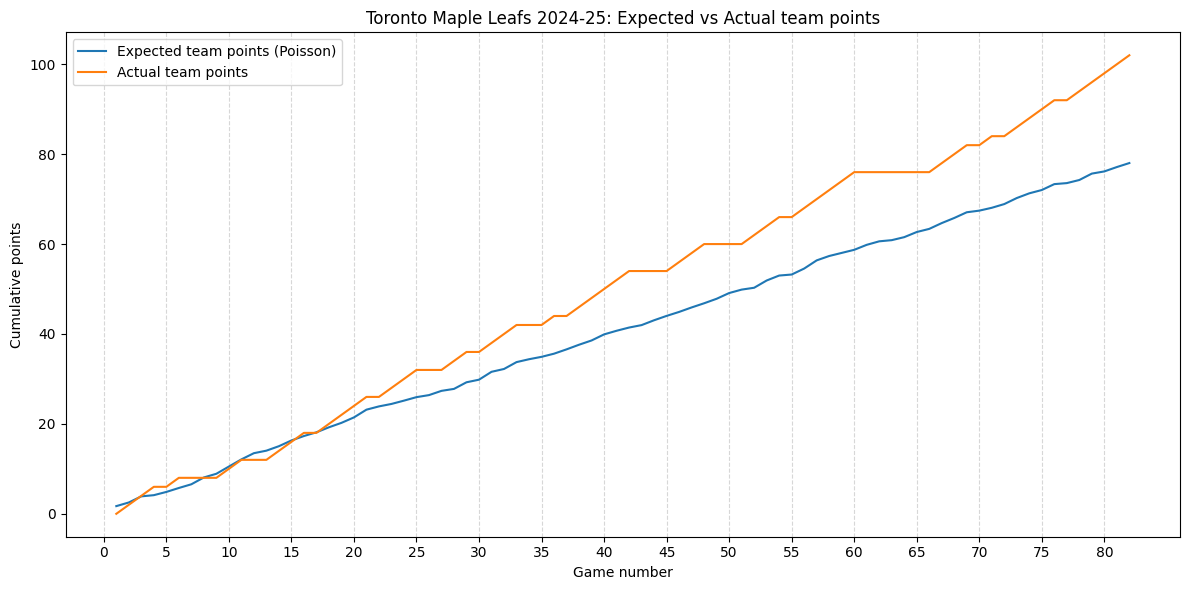

In [8]:
# Step 2: Plot cumulative vs. expected team points

df["cum_exp_points"] = df["exp_points"].cumsum()
df["actual_points"] = np.where(df["GF"] > df["GA"], 2, 0)
df["cum_actual_points"] = df["actual_points"].cumsum()

plt.figure(figsize=(12,6))
plt.plot(df.index+1, df["cum_exp_points"], label="Expected team points (Poisson)")
plt.plot(df.index+1, df["cum_actual_points"], label="Actual team points")
plt.xlabel("Game number")
plt.ylabel("Cumulative points")
plt.title("Toronto Maple Leafs 2024-25: Expected vs Actual team points")
plt.legend()
plt.xticks(ticks=np.arange(0, len(df), 5))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Step 2.2 Observation:**

* The cumulative points show that the leafs consistently outperformed their expected team points throughout the season
*   Stretches where the gaps between the model's predictive ability are seemingly more accurate
*   Stretches where the gap widens indicate relatively stronger performance relative to expectations








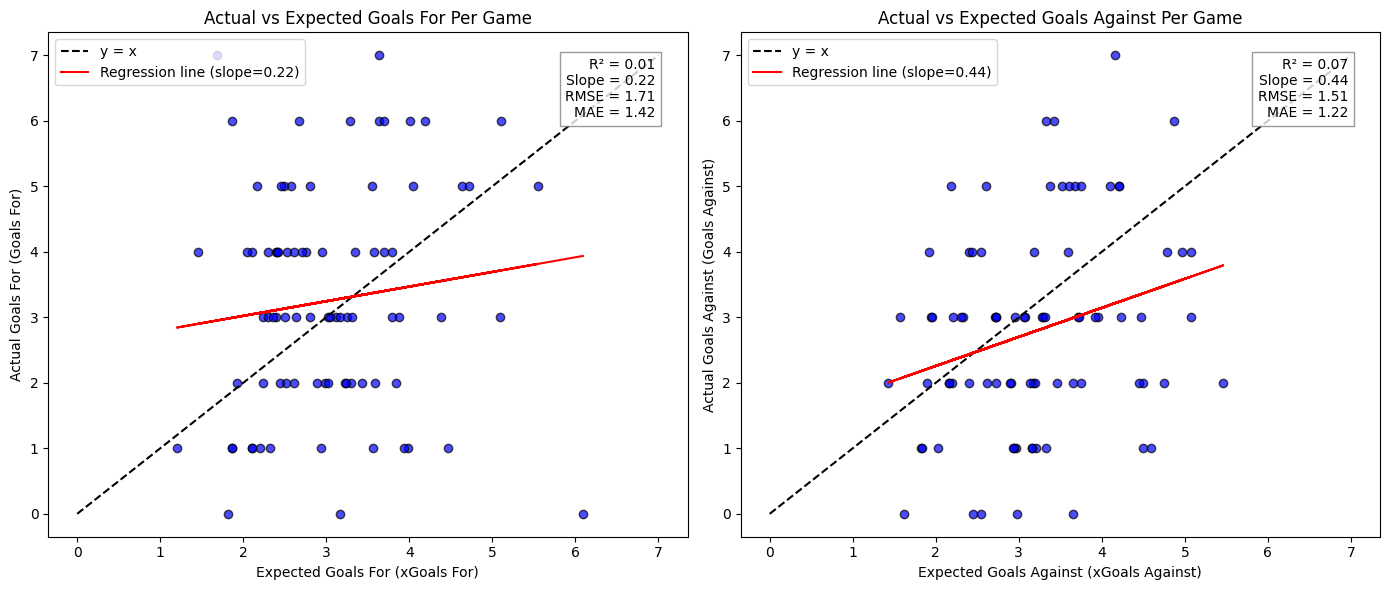

In [9]:
# Step 3: Scatter plots of actual vs expected goals

# y=x assumes expected goals and actual goals have perfect correlation
# Regression line displays the slope of the data points we have
# Box in the top right uses R^2, Slope, RMSE, and MAE to display the accuracy of the slope, the precision of the data, and the deviations of the predictions

fig, axes = plt.subplots(1, 2, figsize=(14,6))

for i, (x_col, y_col, title) in enumerate([("xGF", "GF", "Goals For"), ("xGA", "GA", "Goals Against")]):
    x = df[x_col]
    y = df[y_col]

    # Linear regression
    slope, intercept, r_value, _, _ = linregress(x, y)
    y_pred = intercept + slope * x

    # Calculate R²
    r_squared = r_value**2

    # Metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    # Scatter plot
    axes[i].scatter(x, y, color='blue', edgecolor='k', alpha=0.7)
    axes[i].plot([0, max(x.max(), y.max())], [0, max(x.max(), y.max())], 'k--', label='y = x')  # identity line
    axes[i].plot(x, y_pred, color='red', linestyle='-', label=f'Regression line (slope={slope:.2f})')

    # Display metrics
    textstr = f'R² = {r_squared:.2f}\nSlope = {slope:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}'
    axes[i].text(0.95, 0.95, textstr, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    axes[i].set_xlabel(f'Expected {title} (x{title})')
    axes[i].set_ylabel(f'Actual {title} ({title})')
    axes[i].set_title(f'Actual vs Expected {title} Per Game')
    axes[i].legend()

plt.tight_layout()
plt.show()


**Step 2.3 Observation:**

* In general, the model showed to be a weak predictor of goals for and goals against
* While both goals for and goals against were poor predictors, defense seemed to be a better predictor, although still a weak correlation
* High variance suggets other factors could play an important role that aren't included in this data


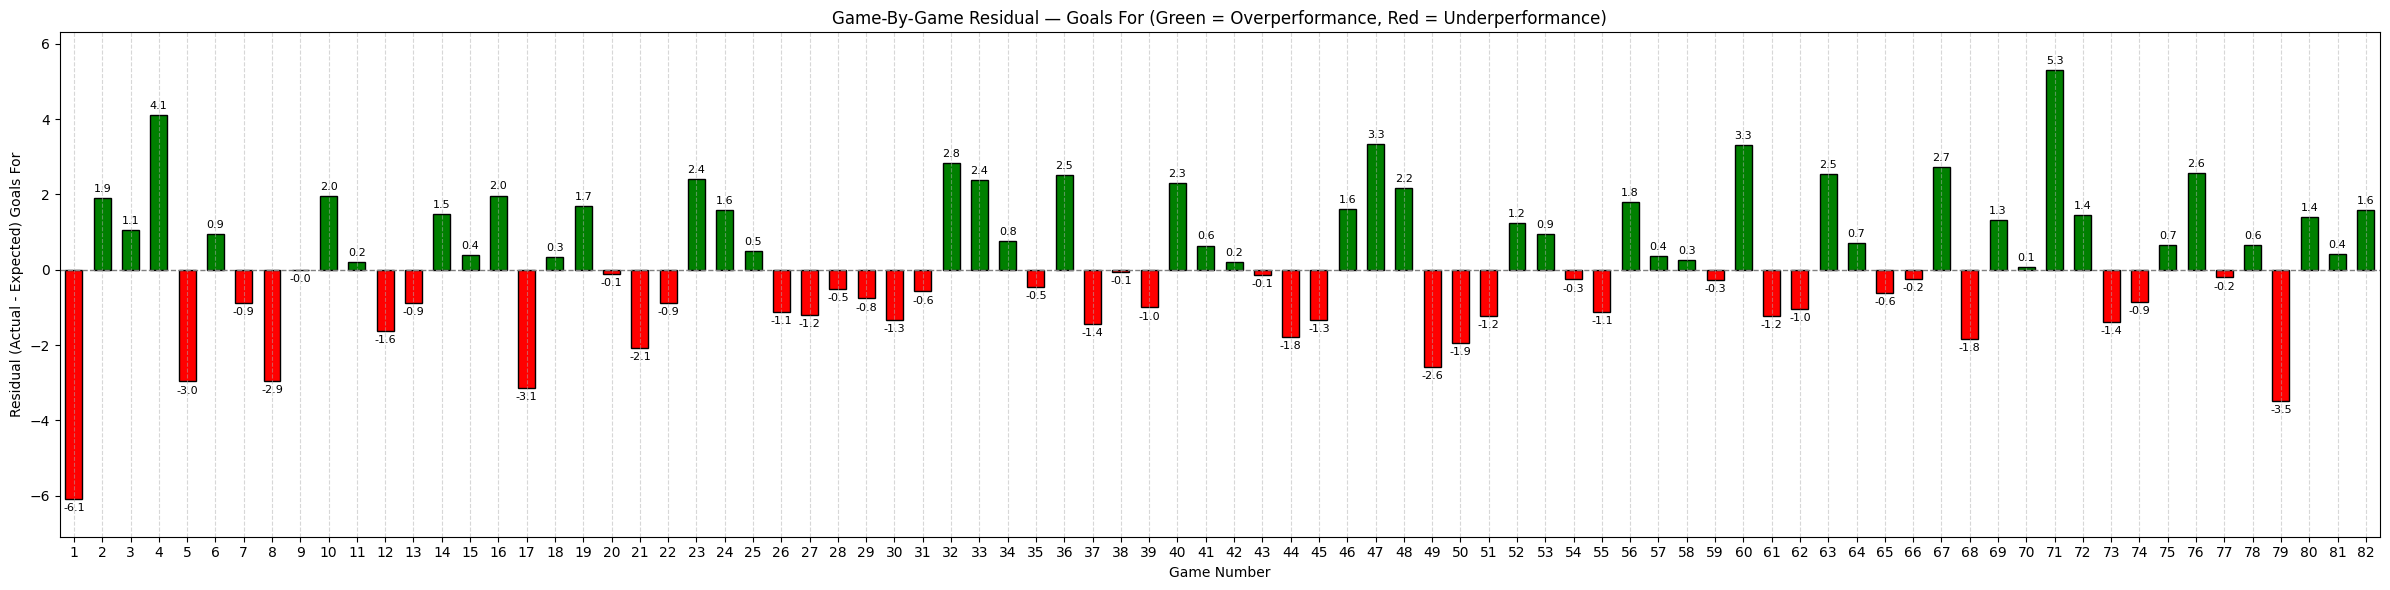

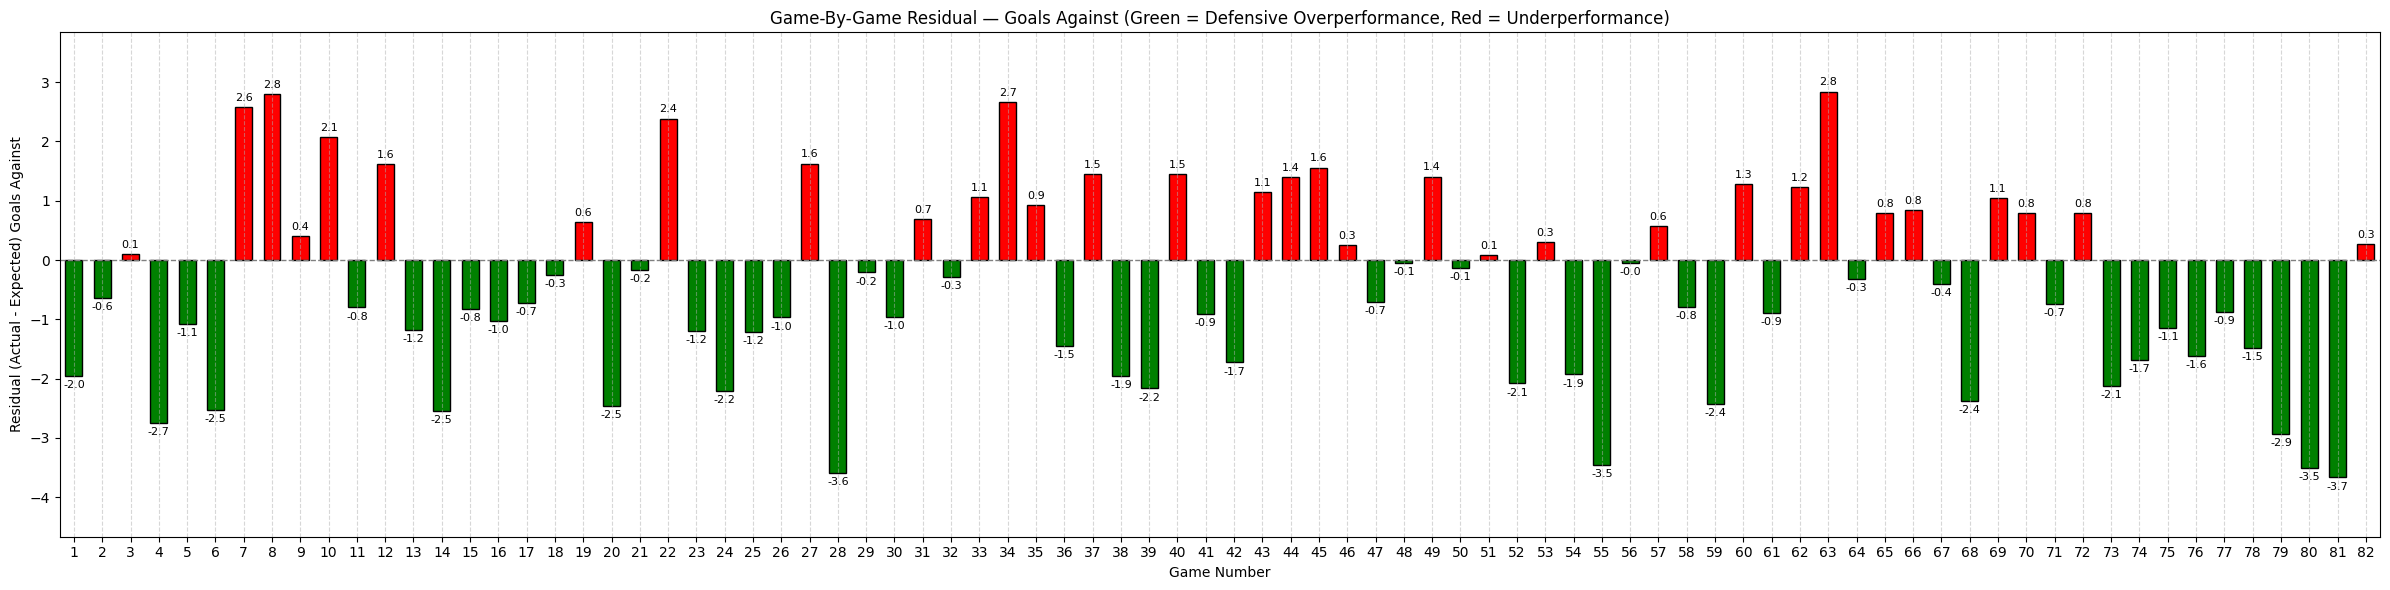

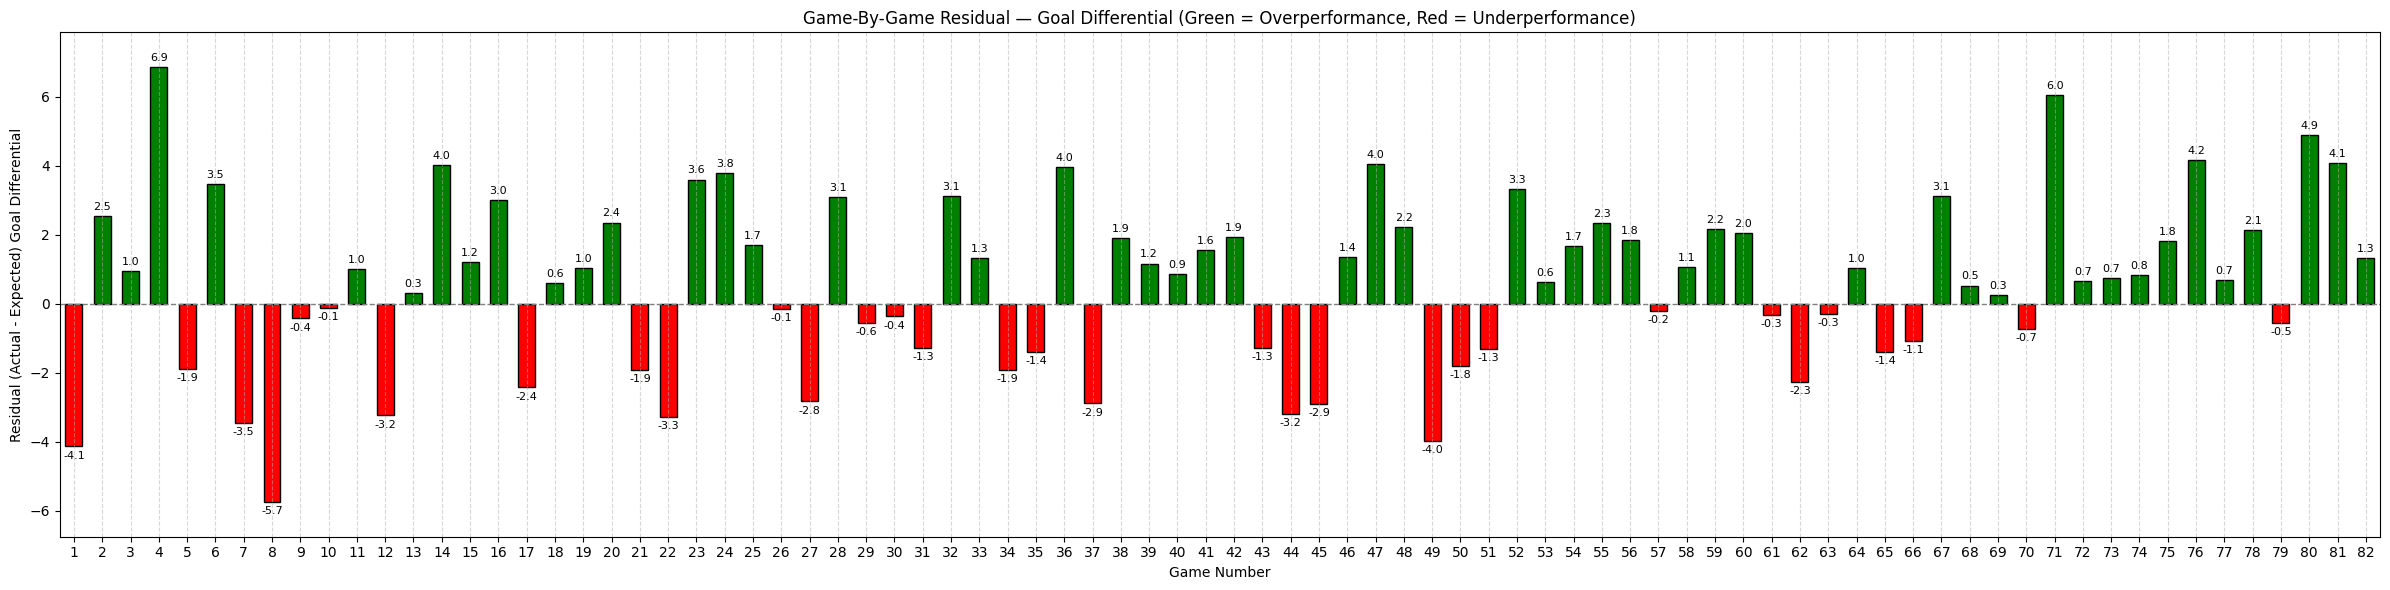

In [10]:
# Step 4: Plot Game-By-Game Residuals For Goals For, Goals Against, And Goal Differential

# Game-by-game residuals = difference between actual and expected goals (or goal differential) for each game
# First plot isolates the residuals of actual and expected goals for, while the second isolates goals against
# Third plot represents the goal differential residuals of the actual and expected goals

# Ensure residual columns exist
if "residual_gf" not in df.columns:
    df["residual_gf"] = df["GF"] - df["exp_goals_for"]

if "residual_ga" not in df.columns:
    df["residual_ga"] = df["GA"] - df["exp_goals_against"]

if "residual_diff" not in df.columns:
    df["expected_goal_diff"] = df["exp_goals_for"] - df["exp_goals_against"]
    df["actual_goal_diff"] = df["GF"] - df["GA"]
    df["residual_diff"] = df["actual_goal_diff"] - df["expected_goal_diff"]

# Plot residuals for goals for
plt.figure(figsize=(24,6))
colors = np.where(df["residual_gf"] >= 0, 'green', 'red')
bars = plt.bar(range(1, len(df)+1), df["residual_gf"], color=colors, edgecolor='k', width=0.6)
plt.bar_label(bars, labels=[f"{val:.1f}" for val in df["residual_gf"]], fontsize=8, padding=3)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Game Number")
plt.ylabel("Residual (Actual - Expected) Goals For")
plt.title("Game-By-Game Residual — Goals For (Green = Overperformance, Red = Underperformance)")
plt.xticks(ticks=range(1, len(df)+1), labels=[str(i) for i in range(1, len(df)+1)])
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0.5, len(df)+0.5)
plt.ylim(df["residual_gf"].min() - 1, df["residual_gf"].max() + 1)
plt.tight_layout()
plt.show()

# Plot residuals for goals against
plt.figure(figsize=(24,6))
colors = np.where(df["residual_ga"] <= 0, 'green', 'red')  # green = allowed fewer goals
bars = plt.bar(range(1, len(df)+1), df["residual_ga"], color=colors, edgecolor='k', width=0.6)
plt.bar_label(bars, labels=[f"{val:.1f}" for val in df["residual_ga"]], fontsize=8, padding=3)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Game Number")
plt.ylabel("Residual (Actual - Expected) Goals Against")
plt.title("Game-By-Game Residual — Goals Against (Green = Defensive Overperformance, Red = Underperformance)")
plt.xticks(ticks=range(1, len(df)+1), labels=[str(i) for i in range(1, len(df)+1)])
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0.5, len(df)+0.5)
plt.ylim(df["residual_ga"].min() - 1, df["residual_ga"].max() + 1)
plt.tight_layout()
plt.show()

# Plot residuals for goal differential
plt.figure(figsize=(24,6))
colors = np.where(df["residual_diff"] >= 0, 'green', 'red')
bars = plt.bar(range(1, len(df)+1), df["residual_diff"], color=colors, edgecolor='k', width=0.6)
plt.bar_label(bars, labels=[f"{val:.1f}" for val in df["residual_diff"]], fontsize=8, padding=3)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Game Number")
plt.ylabel("Residual (Actual - Expected) Goal Differential")
plt.title("Game-By-Game Residual — Goal Differential (Green = Overperformance, Red = Underperformance)")
plt.xticks(ticks=range(1, len(df)+1), labels=[str(i) for i in range(1, len(df)+1)])
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0.5, len(df)+0.5)
plt.ylim(df["residual_diff"].min() - 1, df["residual_diff"].max() + 1)
plt.tight_layout()
plt.show()


**Step 2.4 Observation:**

* Large deviations both positively and negatively suggest high volatility in predictive power
* 58 games show positive residuals compared to 24 which show negative residuals
* This further suggests that the Maple Leafs were far more likely to overperform than underperform the expecatations of this model


In [11]:
# Step 5: Display actual vs expected results for a specific game

# This highlights how a specific game deviated from expectations, linking residual disparities directly to that game

# MUST CHANGE "game_number" TO VIEW CORRESPONDING GAME
game_number = 8  # change to view a different game

if 1 <= game_number <= len(df):
    game = df.iloc[game_number - 1]
    print(f"Game {game_number}: {game['Game']}")
    print(f"Actual GF / GA: {round(game['GF'],1)} / {round(game['GA'],1)}")
    print(f"Expected xGF / xGA: {round(game['xGF'],1)} / {round(game['xGA'],1)}")
    print(f"Expected goal diff: {round(game['xGF']-game['xGA'],1)}")
    print(f"Residual (actual - expected goal diff): {round((game['GF']-game['GA'])-(game['xGF']-game['xGA']),1)}")
else:
    print(f"Invalid game number. Please choose between 1 and {len(df)}")


Game 8:  2024-10-24 - Blues 5, Maple Leafs 1
Actual GF / GA: 1 / 5
Expected xGF / xGA: 3.9 / 2.2
Expected goal diff: 1.8
Residual (actual - expected goal diff): -5.8


In [12]:
# Step 6: Monte Carlo simulation to display expected season wins and team points

n_simulations = 10000  # number of simulated seasons

def monte_carlo_season(df, n_sims=10000):
    """Monte Carlo simulation of total season wins and points."""
    total_wins = np.zeros(n_sims)
    total_points = np.zeros(n_sims)

    for sim in range(n_sims):
        wins, points = 0, 0
        for _, row in df.iterrows():
            goals_for = np.random.poisson(lam=row["xGF"])
            goals_against = np.random.poisson(lam=row["xGA"])
            if goals_for > goals_against:
                wins += 1
                points += 2
            elif goals_for < goals_against:
                points += 0
            else:  # tie: 50/50 coin flip
                if np.random.rand() < 0.5:
                    wins += 1
                    points += 2
        total_wins[sim] = wins
        total_points[sim] = points

    return total_wins, total_points

# Run the simulation
total_wins, total_points = monte_carlo_season(df, n_sims=n_simulations)


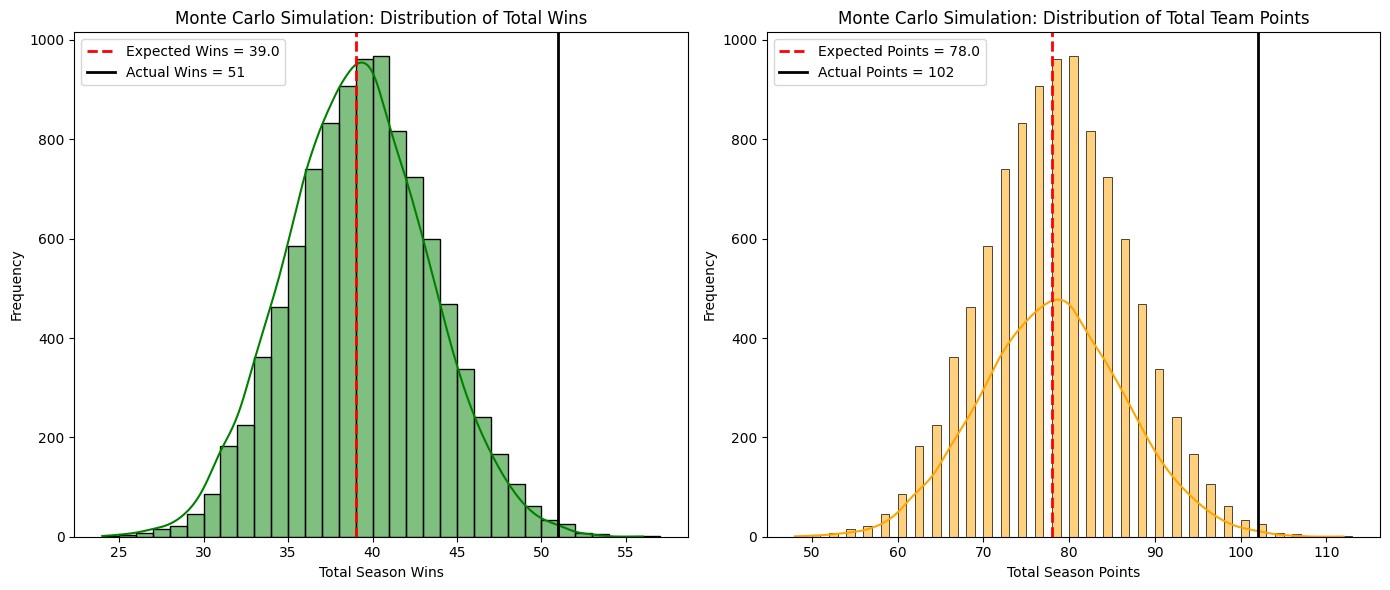

In [13]:
# Step 7: Display probability distributions of total wins and points

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Left: Total Wins ---
sns.histplot(total_wins,
             bins=range(int(total_wins.min()), int(total_wins.max())+2),
             kde=True, color='green', edgecolor='k', ax=axes[0])

expected_wins = df["p_win"].sum()  # Expected wins from model
axes[0].axvline(expected_wins, color='red', linestyle='--', linewidth=2,
                label=f"Expected Wins = {expected_wins:.1f}")

# Actual wins from the real results in df (consistent with how you computed actual_points)
actual_wins = (df["GF"] > df["GA"]).sum()
axes[0].axvline(actual_wins, color='black', linestyle='-', linewidth=2,
                label=f"Actual Wins = {actual_wins}")

axes[0].set_xlabel("Total Season Wins")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Monte Carlo Simulation: Distribution of Total Wins")
axes[0].legend()

# --- Right: Total Points ---
sns.histplot(total_points,
             bins=range(int(total_points.min()), int(total_points.max())+2),
             kde=True, color='orange', edgecolor='k', ax=axes[1])

expected_points = 2 * df["p_win"].sum()
axes[1].axvline(expected_points, color='red', linestyle='--', linewidth=2,
                label=f"Expected Points = {expected_points:.1f}")

# Actual points from df (already defined earlier in your notebook)
# If not defined yet at this point, you can compute it here with the same logic.
actual_points = df["actual_points"].sum() if "actual_points" in df.columns else np.where(df["GF"] > df["GA"], 2, 0).sum()
axes[1].axvline(actual_points, color='black', linestyle='-', linewidth=2,
                label=f"Actual Points = {actual_points}")

axes[1].set_xlabel("Total Season Points")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Monte Carlo Simulation: Distribution of Total Team Points")
axes[1].legend()

plt.tight_layout()
plt.show()


**Step 2.7 Observation:**

* Both wins and team points follow a normal distribution
* As expected goals falls near the peak of the normal distribution, it suggests that xG model provides central tendency
* Due to large variance, the normal distribution suggests poor precision for season predictions

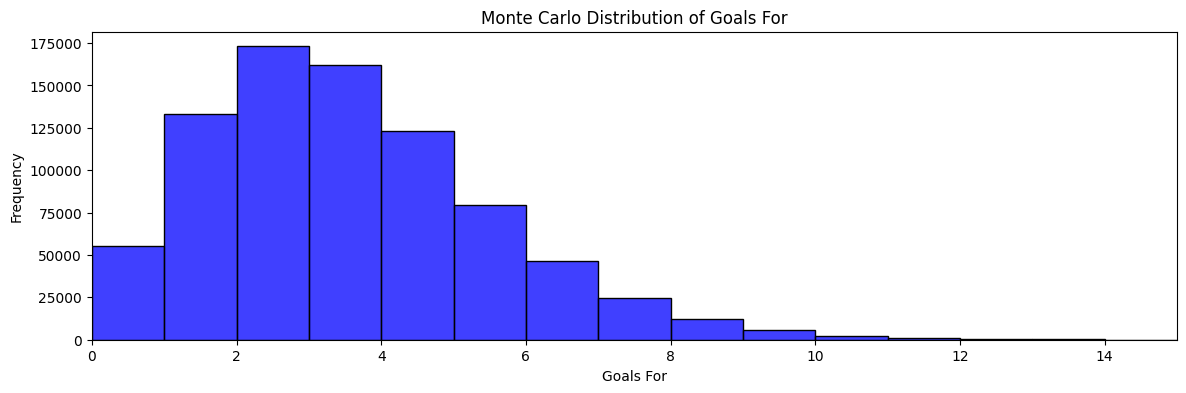

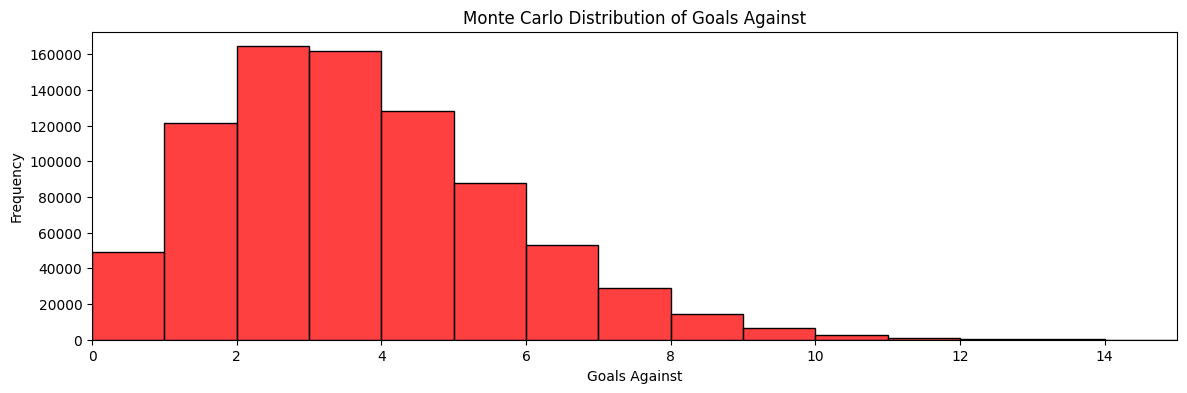

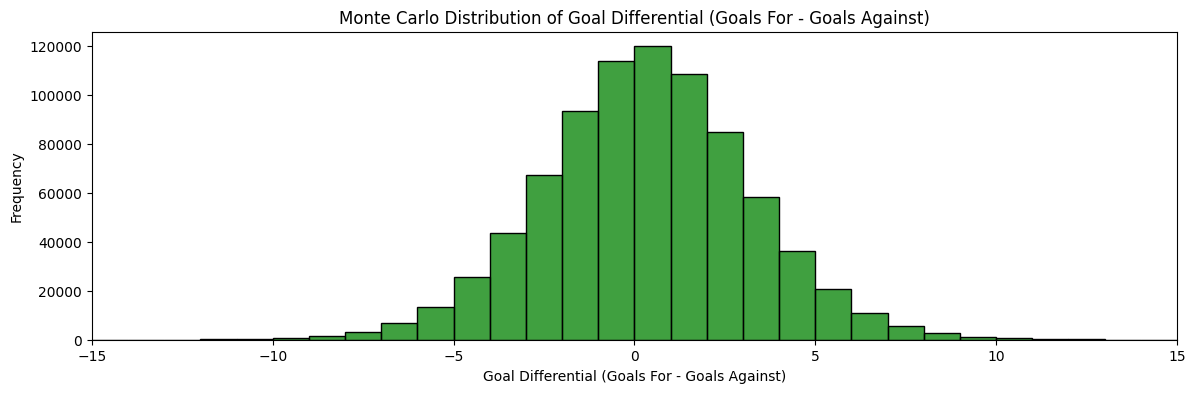

In [14]:
# Step 8: Monte Carlo simulation of expected goals distribution

n_sims_per_game = 10000

def monte_carlo_goals(df, n_sims=10000):
    sim_goals_for, sim_goals_against, sim_goal_diff = [], [], []

    for _, row in df.iterrows():
        goals_for = np.random.poisson(lam=row["xGF"], size=n_sims)
        goals_against = np.random.poisson(lam=row["xGA"], size=n_sims)
        sim_goals_for.extend(goals_for)
        sim_goals_against.extend(goals_against)
        sim_goal_diff.extend(goals_for - goals_against)

    return sim_goals_for, sim_goals_against, sim_goal_diff

# Run the simulation
sim_goals_for, sim_goals_against, sim_goal_diff = monte_carlo_goals(df, n_sims=n_sims_per_game)

# Plotting
def plot_histogram(data, title, color, xlim=None):
    plt.figure(figsize=(14,4))
    sns.histplot(data, bins=range(min(data), max(data)+1), kde=False, color=color, edgecolor='k')
    plt.xlabel(title)
    plt.ylabel("Frequency")
    plt.title(f"Monte Carlo Distribution of {title}")
    if xlim:
        plt.xlim(xlim)
    plt.show()

plot_histogram(sim_goals_for, "Goals For", "blue", xlim=(0,15))
plot_histogram(sim_goals_against, "Goals Against", "red", xlim=(0,15))
plot_histogram(sim_goal_diff, "Goal Differential (Goals For - Goals Against)", "green", xlim=(-15,15))


**Step 2.8 Observations:**

* The distribution for goals for and goals against is right-skewed (positively skewed)
* The greatest frequency of goals for and goals against occurs around 2-4 goals
* Games tend to  most frequently be decided by onde goal accoring to the goals differntial plot